C:\Users\Kirill\Documents\Indie\backtest_quant\venv\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

[*********************100%***********************]  1 of 1 completed


Start                     2022-04-09 00:00:00
End                       2025-03-31 00:00:00
Duration                   1087 days 00:00:00
Exposure Time [%]                    24.81618
Equity Final [$]                 671809.64222
Equity Peak [$]                  782715.02409
Commissions [$]                   23733.26403
Return [%]                           34.36193
Buy & Hold Return [%]               289.55961
Return (Ann.) [%]                    10.41647
Volatility (Ann.) [%]                27.59325
CAGR [%]                             10.42653
Sharpe Ratio                           0.3775
Sortino Ratio                         0.66968
Calmar Ratio                          0.43309
Alpha [%]                           -29.74843
Beta                                  0.22141
Max. Drawdown [%]                   -24.05163
Avg. Drawdown [%]                    -7.30516
Max. Drawdown Duration      372 days 00:00:00
Avg. Drawdown Duration       64 days 00:00:00
# Trades                          

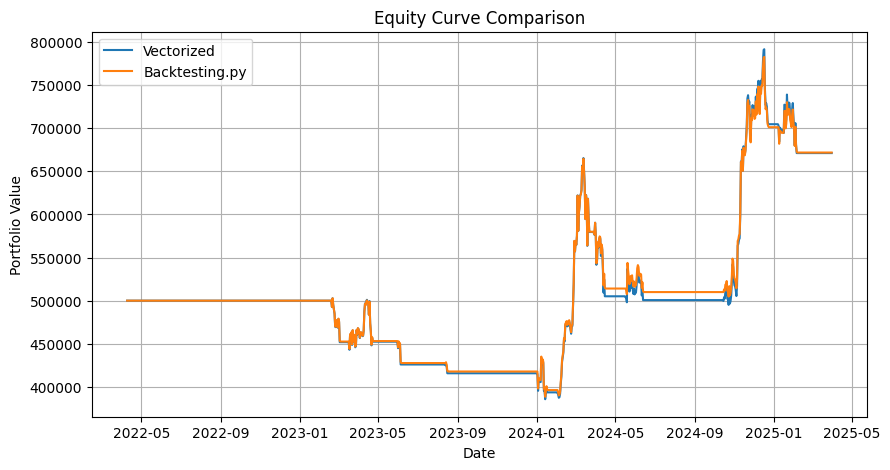

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import functools
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# --- 1) Data Loading & Caching ---
@functools.lru_cache()
def load_data(
    ticker: str = "BTC-USD",
    start: str = "2022-01-01",
    end:   str = "2025-04-01"
) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, auto_adjust=False)
    # Drop ticker-level MultiIndex if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel('Ticker')
    df.index.name = 'Date'
    return df.dropna()

# --- 2) Feature Engineering ---
def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['SMA7']  = df['Close'].rolling(7).mean()
    df['SMA25'] = df['Close'].rolling(25).mean()
    df['SMA99'] = df['Close'].rolling(99).mean()
    return df.dropna()

# --- 3) Signal Generation ---
def make_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    buy = (
        (df['SMA7'] > df['SMA25']) & (df['SMA7'].shift() <= df['SMA25'].shift())
        & (df['SMA7'] > df['SMA99'])
    )
    sell = (
        ((df['SMA7'] < df['SMA25']) & (df['SMA7'].shift() >= df['SMA25'].shift()))
        | (df['SMA7'] < df['SMA99'])
    )
    df['Signal'] = 0
    df.loc[buy, 'Signal']   = 1
    df.loc[sell, 'Signal']  = -1
    df['Position'] = df['Signal'].replace(0, np.nan).ffill().fillna(0).astype(int)
    return df

# --- 4) Refactored Vectorized Backtest ---
def vector_backtest(
    df: pd.DataFrame,
    initial_cash: float = 500_000,
    commission: float = 0.002
) -> pd.DataFrame:
    """
    Simulate trades based on precomputed signals:
     - Buy at next bar's open when Signal == 1
     - Sell at next bar's open when Signal == -1
     - Apply commission on both entry and exit
     - Track cash, position, and equity over time
    """
    df = df.copy()
    cash = initial_cash
    position = 0.0
    equity = []
    # Shift opens for execution: trade at next bar's open
    df['ExecOpen'] = df['Open'].shift(-1)

    for i, row in df.iterrows():
        sig = row['Signal']
        exec_price = row['ExecOpen']
        # Entry
        if sig == 1 and position == 0 and not pd.isna(exec_price):
            # buy as much as possible (fractional)
            position = cash / exec_price
            cash -= position * exec_price * (1 + commission)
        # Exit
        elif sig == -1 and position > 0 and not pd.isna(exec_price):
            cash += position * exec_price * (1 - commission)
            position = 0.0
        # Calculate current equity: cash + position * current close
        equity.append(cash + position * row['Close'])

    df['Equity'] = pd.Series(equity, index=df.index)
    return df

# --- 5) Backtesting.py Strategy ---
class SMASanityCheck(Strategy):
    def init(self):
        # Access pandas Series directly for rolling
        price = self.data.df['Close']
        self.sma7  = self.I(lambda s: s.rolling(7).mean(),  price)
        self.sma25 = self.I(lambda s: s.rolling(25).mean(), price)
        self.sma99 = self.I(lambda s: s.rolling(99).mean(), price)

    def next(self):
        if (not self.position
            and crossover(self.sma7, self.sma25)
            and self.sma7[-1] > self.sma99[-1]):
            self.buy()
        elif (self.position
              and (crossover(self.sma25, self.sma7)
                   or self.sma7[-1] < self.sma99[-1])):
            self.position.close()

# --- 6) Plotting & Comparison ---
def main():
    df = load_data()
    df_ind = add_indicators(df)
    df_sig = make_signals(df_ind)

    df_v = vector_backtest(df_sig)
    price_df = df_sig[['Open','High','Low','Close','Volume']]

    bt = Backtest(
        price_df,
        SMASanityCheck,
        cash=500_000,
        commission=0.002,
        trade_on_close=False
    )
    stats = bt.run()
    print(stats)
    bt.plot()

    plt.figure(figsize=(10,5))
    plt.plot(df_v.index, df_v['Equity'], label='Vectorized')
    eq_bt = stats['_equity_curve']['Equity']
    plt.plot(eq_bt.index, eq_bt.values, label='Backtesting.py')
    plt.title('Equity Curve Comparison')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()

[*********************100%***********************]  1 of 1 completed



Vectorized trades:
     EntryTime     EntryPrice      EntryCash   ExitTime     ExitPrice  \
0  2023-02-18   24640.027344  499000.000000 2023-03-03  22362.923828   
1  2023-03-17   27448.117188  450981.238370 2023-04-23  27591.730469   
2  2023-05-31   27218.412109  451532.205783 2023-06-05  25732.109375   
3  2023-08-13   29283.263672  425118.788250 2023-08-16  28699.802734   
4  2024-01-02   44961.601562  414964.879453 2024-01-17  42742.312500   
5  2024-02-02   43184.964844  392863.462421 2024-03-22  63802.722656   
6  2024-03-29   69893.445312  578481.319096 2024-04-07  69362.554688   
7  2024-04-08   71632.500000  571782.203091 2024-04-15  63419.296875   
8  2024-05-17   67066.210938  504067.076505 2024-06-13  66747.570312   
9  2024-10-15   67042.460938  499660.707229 2024-12-23  94684.343750   
10 2025-01-08   95043.484375  703262.207907 2025-01-12  94488.890625   
11 2025-01-16  100025.765625  696353.720256 2025-02-05  96610.640625   

         ExitCash           PnL  
0   4518

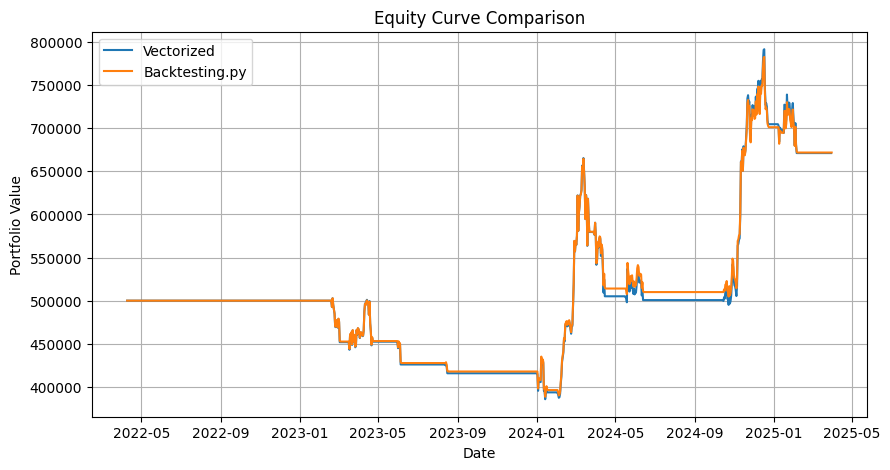

 - CSVs saved:
 - vector_equity.csv
 - vector_trades.csv
 - bt_summary_stats.csv
 - bt_equity_curve.csv
 - bt_trades.csv


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import functools
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# --- 1) Data Loading & Caching ---
@functools.lru_cache()
def load_data(
    ticker: str = "BTC-USD",
    start:  str = "2022-01-01",
    end:    str = "2025-04-01"
) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, auto_adjust=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel('Ticker')
    df.index.name = 'Date'
    return df.dropna()

# --- 2) Feature Engineering ---
def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['SMA7']  = df['Close'].rolling(7).mean()
    df['SMA25'] = df['Close'].rolling(25).mean()
    df['SMA99'] = df['Close'].rolling(99).mean()
    return df.dropna()

# --- 3) Signal Generation ---
def make_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    buy = (
        (df['SMA7'] > df['SMA25']) & (df['SMA7'].shift() <= df['SMA25'].shift())
        & (df['SMA7'] > df['SMA99'])
    )
    sell = (
        ((df['SMA7'] < df['SMA25']) & (df['SMA7'].shift() >= df['SMA25'].shift()))
         | (df['SMA7'] < df['SMA99'])
    )
    df['Signal']   = 0
    df.loc[buy,  'Signal'] =  1
    df.loc[sell, 'Signal'] = -1
    return df

# --- 4) Refactored Vectorized Backtest with Trade Logger ---
def vector_backtest(
    df: pd.DataFrame,
    initial_cash: float = 500_000,
    commission:   float = 0.002
) -> (pd.DataFrame, pd.DataFrame):
    """
    Simulate bar-by-bar PnL given precomputed signals.
    Returns:
      - df: same index, with 'ExecOpen' and 'Equity'
      - trades_v: DataFrame of entry/exit rows + PnL
    """
    df = df.copy()
    cash = initial_cash
    position = 0.0
    equity = []
    trades = []  # will collect trade dicts

    # next-bar open execution price
    df['ExecOpen'] = df['Open'].shift(-1)
    # drop last row where ExecOpen is NaN
    df = df.dropna(subset=['ExecOpen'])

    for idx, row in df.iterrows():
        sig        = row['Signal']
        exec_price = row['ExecOpen']

        # ENTRY
        if sig == 1 and position == 0:
            # size = all‐in fractional
            position = cash / exec_price
            cost     = position * exec_price
            comm     = cost * commission
            cash    -= (cost + comm)
            # log entry
            trades.append({
                'EntryTime':  idx,
                'EntryPrice': exec_price,
                'EntryCash':  cash + cost  # pre‐trade cash
            })

        # EXIT
        elif sig == -1 and position > 0:
            proceeds = position * exec_price
            comm     = proceeds * commission
            cash    += (proceeds - comm)
            # update last trade with exit info
            trades[-1].update({
                'ExitTime':  idx,
                'ExitPrice': exec_price,
                'ExitCash':  cash
            })
            position = 0.0

        # record equity = cash + mark‐to‐market
        equity.append(cash + position * row['Close'])

    # build outputs
    df['Equity'] = pd.Series(equity, index=df.index)
    trades_v = pd.DataFrame(trades)
    trades_v['PnL'] = trades_v['ExitPrice'] - trades_v['EntryPrice']

    return df, trades_v

# --- 5) Backtesting.py Strategy ---
class SMASanityCheck(Strategy):
    def init(self):
        price = self.data.df['Close']
        self.sma7  = self.I(lambda s: s.rolling(7).mean(),  price)
        self.sma25 = self.I(lambda s: s.rolling(25).mean(), price)
        self.sma99 = self.I(lambda s: s.rolling(99).mean(), price)

    def next(self):
        if (not self.position
            and crossover(self.sma7, self.sma25)
            and self.sma7[-1] > self.sma99[-1]):
            self.buy()
        elif (self.position
              and (crossover(self.sma25, self.sma7)
                   or self.sma7[-1] < self.sma99[-1])):
            self.position.close()

# --- 6) Plotting & Comparison ---
def main():
    # load & prep
    df      = load_data()
    df_ind  = add_indicators(df)
    df_sig  = make_signals(df_ind)

    # vectorized run + trade log
    df_v, trades_v = vector_backtest(df_sig)
    print("\nVectorized trades:\n", trades_v)

    # pure price DF for Backtesting.py
    price_df = df_sig[['Open','High','Low','Close','Volume']]

    bt = Backtest(
        price_df, SMASanityCheck,
        cash=500_000,
        commission=0.002,
        trade_on_close=False   # next-bar open execution
    )
    stats = bt.run()
    print("\nBacktesting.py stats:\n", stats)
    bt.plot()

    # equity overlay
    plt.figure(figsize=(10,5))
    plt.plot(df_v.index, df_v['Equity'], label='Vectorized')
    eq_bt = stats['_equity_curve']['Equity']
    plt.plot(eq_bt.index, eq_bt.values, label='Backtesting.py')
    plt.title('Equity Curve Comparison')
    plt.xlabel('Date'); plt.ylabel('Portfolio Value')
    plt.legend(); plt.grid(True)
    plt.show()

    # --- Save vectorized results ---
    df_v.to_csv("vector_equity.csv")
    trades_v.to_csv("vector_trades.csv", index=False)

    # --- Save backtesting.py results ---
    stats.drop(labels=["_equity_curve", "_trades"]).to_csv("bt_summary_stats.csv")
    stats['_equity_curve'].to_csv("bt_equity_curve.csv")
    stats['_trades'].to_csv("bt_trades.csv", index=False)

    print(" - CSVs saved:")
    print(" - vector_equity.csv")
    print(" - vector_trades.csv")
    print(" - bt_summary_stats.csv")
    print(" - bt_equity_curve.csv")
    print(" - bt_trades.csv")



if __name__ == '__main__':
    main()